# Processing & Analysis of Biotek Plate Reader Records

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [ ]:
import sys
sys.path.insert(0, '../../../../')
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import string
import mwc.bayes
import mwc.stats
import mwc.viz
import mwc.fitderiv
import bebi103.viz
import pystan
import tqdm
import os
import csv
colors = mwc.viz.personal_style()
alt.data_transformers.enable('json')

In [1]:
import sys
sys.path.insert(0, '../../../../')
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import mwc.viz
colors = mwc.viz.personal_style()
import mwc.fitderiv
import csv

In [2]:
STRAIN = 'delta'
CARBON = 'glucose'

PER_WELL = False

Need to do well by well GP analysis for high temps (above 37) or maybe for everything, and consider the distribution of growth rates. And use that to calculate errors of the errors? And finalize file names input and output, and pdfs to pngs, and error propogation of doubling time. Also, save time intervals used and reuse them for re analysis. potentially want to run several analysis in a row automatically, but prob too hard unless working with only glucose/delta files. 

save sets of instructions? and run script with the instructions changed as part of the script?
instructions: 
strain
carbon
full and subset plot parameters (start and end times)
GP parameters (start and end times)


also:
plate arrangement for each day
global glyph and color dictionary

In [3]:
# Load the data. 
data = pd.read_csv(f'output/growth_plate.csv')

# Generate a dictionary of the mean blank at each time point. 
blank_vals = {t:val['od_600nm'].mean() for t, val in data[data['strain']=='blank'].groupby(['time_min'])}

# Add mean blank values for each time point to the dataframe, as well as background subtracted OD values.
for k, v in blank_vals.items():
    data.loc[data['time_min']==k, 'blank_val'] = v
data['od_sub'] = data['od_600nm'] - data['blank_val']

# Load time range to be analyzed
ranges_df = pd.read_csv('output/ranges.csv')
XMIN = ranges_df[STRAIN+CARBON][0]
XMAX = ranges_df[STRAIN+CARBON][1]

# Restrict data to desired range.
restricted = data[(data['strain']==STRAIN) & (data['carbon']==CARBON) 
                  & (data['time_min'] > XMIN) & (data['time_min'] < XMAX)].sort_values('time_min')

In [8]:
# Using the package [`fitderiv`](http://swainlab.bio.ed.ac.uk/software/fitderiv/) from Peter Swain's lab, 
# we can perform non-parametric inference of the time-dependent growth rates of these data.
gp = mwc.fitderiv.fitderiv(restricted['time_min'].values, restricted['od_sub'].values)

Taking natural logarithm of the data.
Fitting measurement errors.
Using a squared exponential Gaussian process.
hparam[0] determines the amplitude of variation
hparam[1] determines the flexibility
hparam[2] determines the variance of the measurement error
log(max likelihood)= 4.368464e+03
hparam[0]= 1.071585e+01 [1.000000e-05, 1.000000e+05]
hparam[1]= 3.801924e-06 [1.000000e-06, 1.000000e+02]
hparam[2]= 8.564597e-04 [1.000000e-05, 1.000000e+02]

Calculating statistics with 100 samples
	(displaying mean +/- standard deviation [standard error])

         max df= 4.319913e-03 +/- 1.693363e-05 [1.693363e-06]
 time of max df= 9.473167e+02 +/- 5.365398e+00 [5.365398e-01]
 inverse max df= 1.604564e+02 +/- 6.281820e-01 [6.281820e-02]
          max y= 1.703347e-01 +/- 4.510613e-04 [4.510613e-05]
       lag time= 6.658637e+02 +/- 1.109004e+00 [1.109004e-01]


In [17]:
# Export summary statistics.
stats = gp.printstats(performprint=False)
with open(f'output/{STRAIN}_{CARBON}_GP_summary.csv','w') as f:
    w = csv.writer(f)
    w.writerow(['parameter','value'])
    w.writerows(stats.items())

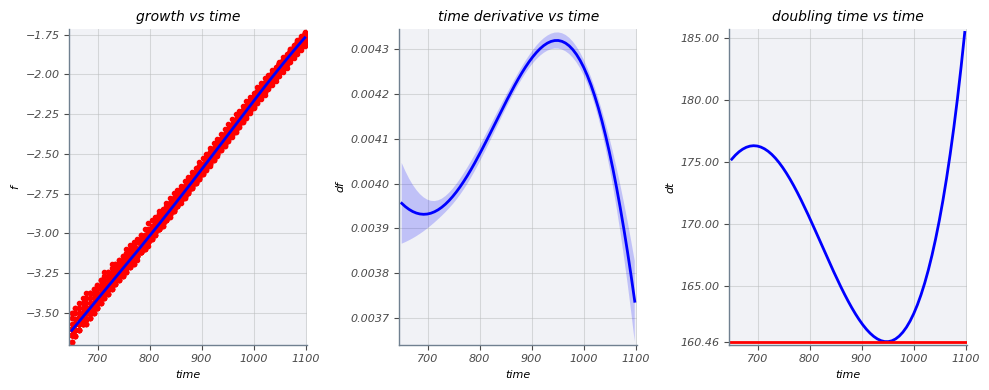

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1,3,1)
plt.title('growth vs time', fontsize = 10)
gp.plotfit('f')
plt.subplot(1,3,2)
plt.title('time derivative vs time', fontsize=10)
gp.plotfit('df')
plt.subplot(1,3,3)
plt.title('doubling time vs time', fontsize=10)
gp.plotfit('dt', errorfac = 1000)
plt.axhline(y=stats['inverse max df'],c='red')
locs, _ = plt.yticks()
plt.yticks(np.append(locs[1:-1],round(stats['inverse max df'],2)))
plt.tight_layout()
plt.savefig(f'output/{STRAIN}_{CARBON}_GP_fit_and_time_derivative.png')

In [ ]:
if PER_WELL:
    well_stats = []
    
    for well in restricted['well_id']:
        subset = restricted[restricted['well_id'] == well]
        
        gp = mwc.fitderiv.fitderiv(subset['time_min'].values, subset['od_sub'].values)
        stats = gp.printstats(performprint=False)
        with open(f'output/per_well/{STRAIN}_{CARBON}_GP_summary_{well}.csv','w') as f:
            w = csv.writer(f)
            w.writerow(['parameter','value'])
            w.writerows(stats.items())
        
        well_stats.append(pd.DataFrame(stats))
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1,3,1)
        plt.title('growth vs time', fontsize = 10)
        gp.plotfit('f')
        plt.subplot(1,3,2)
        plt.title('time derivative vs time', fontsize=10)
        gp.plotfit('df')
        plt.subplot(1,3,3)
        plt.title('doubling time vs time', fontsize=10)
        gp.plotfit('dt')
        plt.axhline(y=stats['inverse max df'],c='red')
        locs, _ = plt.yticks()
        plt.yticks(np.append(locs[1:-1],round(stats['doubling time'],2)))
        plt.tight_layout()
        plt.savefig(f'output/{STRAIN}_{CARBON}_GP_fit_and_time_derivative_{well}.png')
    
    well_data = pd.concat(well_stats)
    well_data['carbon'] = CARBON
    well_data['strain'] = STRAIN
    well_data.to_csv('per_well_stats.csv', index=False)

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1,3,1)
plt.title('growth vs time', fontsize = 10)
gp.plotfit('f')
plt.subplot(1,3,2)
plt.title('time derivative vs time', fontsize=10)
gp.plotfit('df')
plt.subplot(1,3,3)
plt.title('doubling time vs time', fontsize=10)
gp.plotdoubtime()
plt.axhline(y=stats['doubling time'],c='red')
locs, _ = plt.yticks()
plt.yticks(np.append(locs[1:-1],round(stats['doubling time'],2)))
plt.tight_layout()
plt.savefig(f'output/{STRAIN}_{CARBON}_GP_fit_and_time_derivative.png')